# My First Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/getting_started/my_first_model.ipynb)


This guide will walk you through creating and training your first simulation-based inference model using GenSBI. We will cover the essential steps, from defining a simulator to training a neural density estimator.

As a first step, make sure GenSBI is installed in your environment. If you haven't done so yet, please refer to the [Installation Guide](/getting_started/installation) before proceeding, or simply run:

In [1]:
# step 1: install packages
# %pip install --quiet  "GenSBI[cuda12,examples] @ git+https://github.com/aurelio-amerio/GenSBI.git" 

Next, it is convenient to download the GenSBI-examples package, which contains several example notebooks and checkpoints, including this one. You can do so by running:

In [2]:
# step 2: clone the examples repository
# !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples.git 

In [3]:
# step 3: cd into the examples folder
# %cd GenSBI-examples/examples/getting_started/GenSBI-examples

In [4]:
# automatically install dependencies if using Colab
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

if colab: # you may have to restart the runtime after installing the packages
    %pip install --quiet "gensbi[cuda12, examples] @ git+https://github.com/aurelio-amerio/GenSBI"
    !git clone --depth 1 https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/getting_started

> **Important**: <br><br>
> If you are using Colab, you may need to restart the runtime after installation to ensure all packages are properly loaded. <br>

Import the necessary modules from GenSBI and other libraries. If you don't have a GPU available, set `JAX_PLATFORMS` to "cpu" in the cell below, but note that training will be significantly slower.

If you encounter import errors after installing, restart the notebook kernel and re-run this cell.

In [5]:
import os

# Set JAX backend (use 'cuda' for GPU, 'cpu' otherwise)
os.environ["JAX_PLATFORMS"] = "cuda"
# os.environ["JAX_PLATFORMS"] = "cpu"

import grain
import numpy as np
import jax
from jax import numpy as jnp
from numpyro import distributions as dist
from flax import nnx

from gensbi.recipes import Flux1FlowPipeline
from gensbi.models import Flux1Params

from gensbi.utils.plotting import plot_marginals
import matplotlib.pyplot as plt

/home/aure/miniforge3/envs/gensbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The simulator

The first step in SBI is defining a **simulator**. The simulator takes input parameters $	heta$ and produces synthetic observations $x$. For this tutorial, we use a simple simulator where the observation $x$ is drawn from a Gaussian distribution centered at $	heta$.

The simulator takes in a parameter vector `theta` of size 3 and returns an observation vector `xs` of size 3. 

In the context of posterior density estimation (Simulation-Based Inference), our goal is to infer the parameters `theta` given an observation `xs`. Therefore, `theta` is the target variable (what we want to predict the distribution of) and `xs` is the condition.

In [6]:
dim_obs = 3 # dimension of the observation (theta), that is the simulator input shape
dim_cond = 3 # dimension of the condition (xs), that is the simulator output shape
dim_joint = dim_obs + dim_cond # dimension of the joint (theta, xs), useful later

def _simulator(key, thetas):

    xs = thetas + 1 + jax.random.normal(key, thetas.shape) * 0.1

    thetas = thetas[..., None]
    xs = xs[..., None]

    # when making a dataset for the joint pipeline, thetas need to come first
    data = jnp.concatenate([thetas, xs], axis=1)

    return data

Next, we define a **prior distribution** $p(	heta)$, which represents our knowledge about the parameters before observing any data. Here, we use a Uniform prior.

In [7]:
theta_prior = dist.Uniform(
    low=jnp.array([-2.0, -2.0, -2.0]), high=jnp.array([2.0, 2.0, 2.0])
)

For convenience, we define a wrapper function that handles both prior sampling and data generation in a single call.

In [8]:
def simulator(key, nsamples):
    theta_key, sample_key = jax.random.split(key, 2)
    thetas = theta_prior.sample(theta_key, (nsamples,))

    return _simulator(sample_key, thetas)

## The dataset

We generate a training dataset by running the simulator multiple times. We sample parameters from the prior and then run the simulator for each parameter set. This dataset of $(	heta, x)$ pairs is used to train the neural density estimator.

GenSBI is designed to work with any dataset that provides an iterator yielding pairs of (parameters, observations). 
However, for efficient training, especially with large datasets, we recommend using a high-performance data loader like `grain` to handle batching, shuffling, and prefetching.

In [9]:
# Define your training and validation datasets.
train_data = simulator(jax.random.PRNGKey(0), 100_000)
val_data = simulator(jax.random.PRNGKey(1), 2000)

In [10]:
# utility function to split data into observations and conditions
def split_obs_cond(data):
    return data[:, :dim_obs], data[:, dim_obs:]  # assuming first dim_obs are obs, last dim_cond are cond

We create a `grain` dataset with batch size = 256. The larger the batch size, the more stable the training.

Adjust according to your hardware capabilities, e.g. GPU memory (try experimenting with 256, 512, 1024, etc).


In [11]:
batch_size = 256

train_dataset_grain = (
    grain.MapDataset.source(np.array(train_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() # If you use prefetching in a .py script, make sure your python script is thread safe, see https://docs.python.org/3/library/multiprocessing.html
)

val_dataset_grain = (
    grain.MapDataset.source(np.array(val_data))
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_obs_cond)
    .mp_prefetch() 
)

Because we called `.repeat()`, these dataloaders cycle through the data indefinitely, which is required for step-based training.
You can get samples from the dataset using:

In [12]:
iter_dataset = iter(train_dataset_grain)
obs,cond = next(iter_dataset)  # returns a batch of (observations, conditions)
print(obs.shape, cond.shape)  # should print (batch_size, dim_obs, 1), (batch_size, dim_cond, 1)

(256, 3, 1) (256, 3, 1)


## The Model

We now set up the **Neural Density Estimator**. We use `Flux1`, a state-of-the-art transformer-based flow matching model. While this architecture is overkill for a simple Gaussian problem, we use it here to demonstrate the standard workflow for complex tasks.

In [13]:
# define the model parameters
params = Flux1Params(
    in_channels=1,  # each observation/condition feature has only one channel (the value itself)
    vec_in_dim=None,
    context_in_dim=1,
    mlp_ratio=3,  # default value
    num_heads=4,  # number of transformer heads
    depth=4,  # number of double-stream transformer blocks
    depth_single_blocks=8,  # number of single-stream transformer blocks
    val_emb_dim=10,  # Features per head for value embedding
    id_emb_dim=4,  # Features per head for ID embedding
    qkv_bias=True,  # default
    dim_obs=dim_obs,  # dimension of the observation (theta)
    dim_cond=dim_cond,  # dimension of the condition (xs)
    id_merge_mode="concat",
    id_embedding_strategy=("absolute", "absolute"),
    rngs=nnx.Rngs(default=42),  # random number generator seed
    param_dtype=jnp.bfloat16,  # data type of the model parameters. if bfloat16 is not available on your machine, use float32
)


# you can also try the "sum" embedding strategy, how does the performance of the model compare? Why? Hint: this is a low dimensional problem, with small axes_dim
# params = Flux1Params(
#     in_channels=1,  # each observation/condition feature has only one channel (the value itself)
#     vec_in_dim=None,
#     context_in_dim=1,
#     mlp_ratio=3,  # default value
#     num_heads=2,  # number of transformer heads
#     depth=4,  # number of double-stream transformer blocks
#     depth_single_blocks=8,  # number of single-stream transformer blocks
#     axes_dim = [10], # Features per head for value embedding
#     qkv_bias=True,  # default
#     dim_obs=dim_obs,  # dimension of the observation (theta)
#     dim_cond=dim_cond,  # dimension of the condition (xs)
#     id_merge_mode="sum",
#     id_embedding_strategy=("absolute", "absolute"),
#     rngs=nnx.Rngs(default=42),  # random number generator seed
#     param_dtype=jnp.bfloat16,  # data type of the model parameters. if bfloat16 is not available on your machine, use float32
# )

Next, we configure the training hyperparameters. We start from the default training configuration and customize a few key settings:

In [14]:
checkpoint_dir = f"{os.getcwd()}/checkpoints"

training_config = Flux1FlowPipeline.get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir
training_config["experiment_id"] = 1
training_config["nsteps"] = 10_000
training_config["decay_transition"] = 0.80
training_config["warmup_steps"] = 500

 > **Note:**<br>
 > It is important to set the number of training steps (`nsteps`) in the training config, as this will ensure warmup steps and decay transition are computed correctly.  

In [15]:
# Instantiate the pipeline
pipeline = Flux1FlowPipeline(
    train_dataset_grain,
    val_dataset_grain,
    dim_obs,
    dim_cond,
    params=params,
    training_config=training_config,
)

## Training

Now we train the model. The number of training steps was already set in the training configuration above. We only need to provide a random number generator for reproducibility.

In [16]:
rngs = nnx.Rngs(42)

In [17]:
# # uncomment to train the model
# loss_history = pipeline.train(
#     rngs, save_model=False
# )  # if you want to save the model, set save_model=True

Alternatively, you can skip training and load the pre-trained checkpoint provided with this example:

In [18]:
pipeline.restore_model(2) # we have stored the pretrained model with tag 2

Restored model from checkpoint


## Next steps

Congratulations! You have successfully created and trained your first simulation-based inference model using GenSBI. You can now experiment with different simulators, priors, and neural density estimators to explore more complex inference tasks.

For more examples, please refer to the [Examples Section](/examples) of the GenSBI documentation.

As a next step, you might want to explore how to validate the performance of your trained model using techniques such as simulation-based calibration (SBC) or coverage plots. These methods help assess the quality of the inferred posterior distributions and ensure that your model is providing accurate uncertainty estimates.

## Posterior calibration tests

In this section, we perform posterior calibration tests using Simulation-Based Calibration (SBC), Targeted At Random Parameters (TARP) and L-C2ST methods to evaluate the quality of our trained model's posterior estimates.

For a full overview of posterior calibration tests, refer to the [sbi documentation](https://sbi.readthedocs.io/en/latest/how_to_guide.html#diagnostics). 

In [19]:
# imports
from gensbi.diagnostics import check_tarp, run_tarp, plot_tarp
from gensbi.diagnostics import check_sbc, run_sbc, sbc_rank_plot
from gensbi.diagnostics import LC2ST, plot_lc2st

We sample 200 new observations from the simulator to perform the calibration tests.
It is crucial that we use a seed different from the one used during training to avoid biased results.

In [35]:
key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = simulator(jax.random.PRNGKey(1), 500)


# split in thetas and xs
thetas_ = test_data[:, :dim_obs, :] # (200, 3, 1)
xs_ = test_data[:, dim_obs:, :] # (200, 3, 1)


In [37]:
# sample the posterior for each observation in xs_
posterior_samples_ = pipeline.sample_batched(jax.random.PRNGKey(0), xs_, nsamples=1_000)  # (1000, 200, 3, 1)

Sampling: 100%|██████████| 20/20 [02:49<00:00,  8.50s/it]


For the sake of posterior calibration tests, the last two dimensions need to be flattened into a single dimension.

In [38]:
thetas = thetas_.reshape(thetas_.shape[0], -1)  # (200, 3)
xs = xs_.reshape(xs_.shape[0], -1)  # (200, 3)
posterior_samples = posterior_samples_.reshape(posterior_samples_.shape[0], posterior_samples_.shape[1], -1)  # (1000, 200, 3)

# Marginal posteriors 

In [39]:
from gensbi.diagnostics.marginal_coverage import compute_marginal_coverage, plot_marginal_coverage

# Compute marginal coverage
# thetas: (200, 3)
# posterior_samples: (1000, 200, 3)
alpha_values = compute_marginal_coverage(thetas, posterior_samples,grid_points=5000)



Computing coverage for dimension 1/3


Computing coverage for dimension 2/3


Computing coverage for dimension 3/3


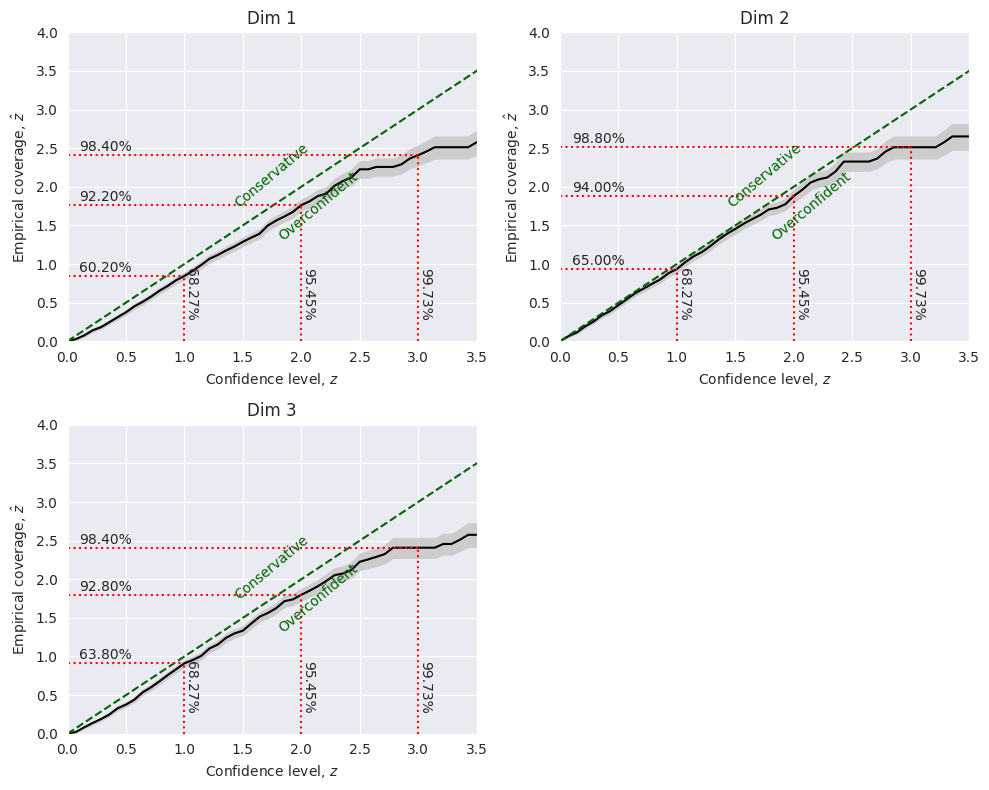

In [40]:
# Plot
fig = plot_marginal_coverage(alpha_values[:3], n_cols=2)
plt.show()